# Telco Customer Churn Prediction: Consolidated Model Guide

This notebook provides a complete guide to building and optimizing machine learning models to predict customer churn. We will cover **6 Models**:

1.  **Logistic Regression**
2.  **Decision Tree**
3.  **K-Nearest Neighbors (KNN)**
4.  **Naive Bayes**
5.  **Random Forest**
6.  **XGBoost**

For each model, we will explain:
*   **The Issue:** Common problems that affect this specific model (e.g., overfitting, sensitivity to scale, class imbalance).
*   **The Solution:** How we fix it in the code (e.g., Scaling, SMOTE, Hyperparameter Tuning).

In [4]:
# 0. Install Dependencies (Run this if you get 'ModuleNotFoundError')
# %pip install pandas numpy scikit-learn matplotlib seaborn xgboost imbalanced-learn

In [5]:
# 1. Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Machine Learning Tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Handle Imbalanced Data
try:
    from imblearn.over_sampling import SMOTE
    print("SMOTE is available for handling class imbalance.")
except ImportError:
    print("SMOTE not found. Will use standard training data.")
    SMOTE = None

SMOTE is available for handling class imbalance.


## 2. Data Preparation

**Issue:** Machine Learning models assume numbers. If data is text (categorical), it needs encoding. If data has different ranges (e.g., tenure 1-72 vs MonthlyCharges 20-100), some models get confused.

**Solution:**
1.  **Encoding:** Already done in `processed_telco.csv`.
2.  **Scaling:** We use `StandardScaler` to make all features have similar ranges (mean=0, variance=1). This is critical for Logistic Regression and KNN.
3.  **Splitting:** We split data into Training (80%) and Testing (20%) to see how well the model generalizes to new data.

In [6]:
# Load our prepared data
df = pd.read_csv("../data/processed_telco.csv")

# Separate Features (X) and Target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Scale the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split into Train and Test sets
# stratify=y ensures we keep the same proportion of Churners in both sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (5634, 32)
Testing Data Shape: (1409, 32)


### Handling Class Imbalance (SMOTE)

**Issue:** In Churn datasets, usually fewer people churn (e.g., 26%) than stay (74%). Models become lazy and just predict "Stay" to get high accuracy (e.g., 74%), but fail to catch the actual churners.

**Solution:** **SMOTE (Synthetic Minority Over-sampling Technique)**. It creates fake, realistic examples of Churners in the Training data so the model sees a 50/50 balance. **Important:** Only apply SMOTE to Training data, never Test data.

In [7]:
# Apply SMOTE to Training Data ONLY (if available)
if SMOTE is not None:
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    print("Before SMOTE:")
    print(y_train.value_counts())
    print("\nAfter SMOTE:")
    print(y_train_resampled.value_counts())
else:
    print("SMOTE unavailable. Using original training data.")
    X_train_resampled, y_train_resampled = X_train, y_train

Before SMOTE:
Churn
0    4139
1    1495
Name: count, dtype: int64

After SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64


---

## 3. Model Implementation

We will now implement all models. For each, we define a "Tuned" version that addresses its weaknesses.

### Model 1: Logistic Regression

**The Issue:** It tries to draw a straight line to separate classes. If features aren't scaled, one feature dominates. It also struggles with imbalance.

**The Solution:** 
*   We used `StandardScaler` (done above).
*   We tune `C` (regularization) to prevent overfitting.
*   We use the SMOTE-balanced data.

In [8]:
# Logistic Regression Tuning
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear'] # Good for small/medium datasets
}

lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=5, scoring='f1')
lr_grid.fit(X_train_resampled, y_train_resampled)

lr_best = lr_grid.best_estimator_
print(f"Best Logistic Regression Params: {lr_grid.best_params_}")

Best Logistic Regression Params: {'C': 10, 'solver': 'liblinear'}


### Model 2: Decision Tree

**The Issue:** **Overfitting**. A tree can grow until it memorizes every single customer in the training data (creating a complex rule like "If tenure=31.5 and charge=20.1..."). This fails on new data.

**The Solution:** **Pruning**. We limit `max_depth` (how deep the tree grows) and `min_samples_leaf` (how many people needed to make a new rule).

In [9]:
# Decision Tree Tuning
dt_params = {
    'max_depth': [5, 10, None], # Limit depth to prevent memorization
    'min_samples_leaf': [2, 5, 10], # Require minimum samples in a leaf
    'criterion': ['gini']
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='f1')
dt_grid.fit(X_train_resampled, y_train_resampled)

dt_best = dt_grid.best_estimator_
print(f"Best Decision Tree Params: {dt_grid.best_params_}")

Best Decision Tree Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10}


### Model 3: K-Nearest Neighbors (KNN)

**The Issue:** It looks at the 'k' closest customers. If one feature (TotalCharges) is in thousands and another (Tenure) is in tens, distance means nothing. It's also slow.

**The Solution:** 
*   **Scaling** (Crucial! We did this earlier).
*   Tune `n_neighbors` (k). Too small (k=1) = noisy. Too big (k=50) = too smooth.

In [10]:
# KNN Tuning
knn_params = {
    'n_neighbors': [3, 5, 7, 11],
    'weights': ['distance'] # Closer neighbors count more
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='f1')
knn_grid.fit(X_train_resampled, y_train_resampled)

knn_best = knn_grid.best_estimator_
print(f"Best KNN Params: {knn_grid.best_params_}")

Best KNN Params: {'n_neighbors': 3, 'weights': 'distance'}


### Model 4: Naive Bayes

**The Issue:** It assumes all features are **independent** (e.g., assumes having Internet Service has nothing to do with Monthly Charges, which is false). This makes it less accurate for complex relationships.

**The Solution:** There aren't many parameters to tune. We use `var_smoothing` to help with numerical stability.

In [11]:
# Naive Bayes Tuning
nb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

nb_grid = GridSearchCV(GaussianNB(), nb_params, cv=5, scoring='f1')
nb_grid.fit(X_train_resampled, y_train_resampled)

nb_best = nb_grid.best_estimator_
print(f"Best Naive Bayes Params: {nb_grid.best_params_}")

Best Naive Bayes Params: {'var_smoothing': 1e-09}


### Model 5: Random Forest

**The Issue:** It builds hundreds of Decision Trees. It's powerful but slow and complex. It can still overfit if trees are too deep.

**The Solution:** 
*   Limit `max_depth`.
*   Use `class_weight='balanced'` inside the model (an alternative to SMOTE, helping it pay attention to the minority class).

In [12]:
# Random Forest Tuning
# Note: We train on original X_train (not SMOTE) but use class_weight='balanced'
# This effectively handles imbalance internally.
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'class_weight': ['balanced']
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1')
rf_grid.fit(X_train, y_train)

rf_best = rf_grid.best_estimator_
print(f"Best Random Forest Params: {rf_grid.best_params_}")

Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}


### Model 6: XGBoost

**The Issue:** The most complex model. It boosts weak trees into strong ones. Prone to overfitting on noise.

**The Solution:** 
*   Tune `learning_rate` (how fast it learns).
*   Use `scale_pos_weight` to help with imbalance (ratio of Negatives/Positives).

In [13]:
# XGBoost Tuning
# Calculate ratio for scale_pos_weight
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'scale_pos_weight': [ratio]
}

xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, cv=3, scoring='f1')
xgb_grid.fit(X_train, y_train)

xgb_best = xgb_grid.best_estimator_
print(f"Best XGBoost Params: {xgb_grid.best_params_}")

c:\Users\singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:59:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:59:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:59:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:59:30] WARNING: C:\actio

Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': np.float64(2.768561872909699)}


c:\Users\singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:59:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


---

## 4. Final Comparison

Now we run all 6 optimized models on the **Test Set** (data they have never seen) to see which one performs best.

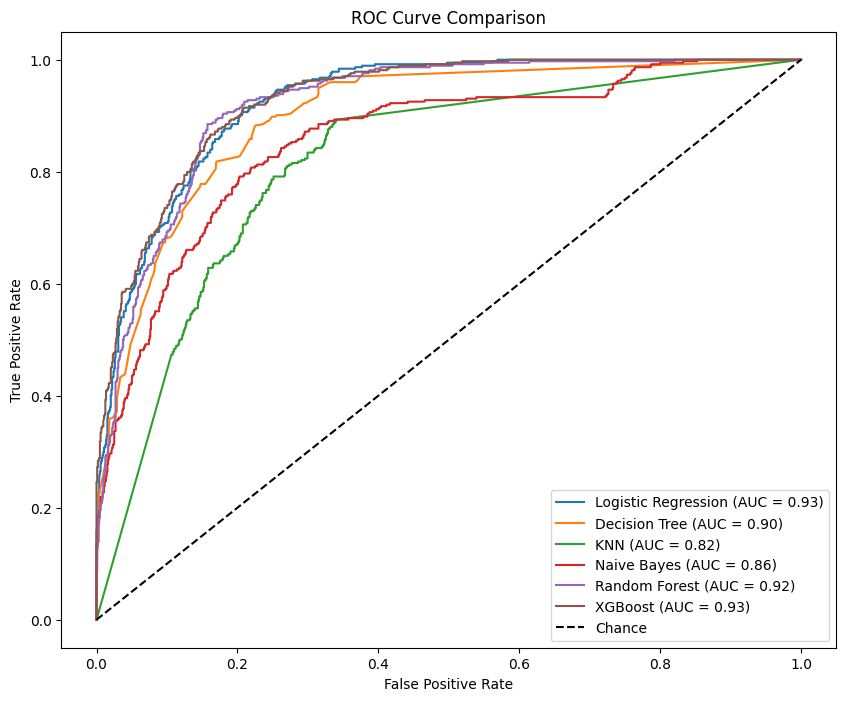

,Model,Accuracy,F1 Score,AUC Score
4,Random Forest,0.850958,0.752941,0.920143
5,XGBoost,0.846700,0.743468,0.929372
0,Logistic Regression,0.833925,0.734694,0.926092
1,Decision Tree,0.823989,0.708235,0.900526
2,KNN,0.766501,0.619653,0.815954
3,Naive Bayes,0.687722,0.607143,0.857511


In [14]:
models = {
    "Logistic Regression": lr_best,
    "Decision Tree": dt_best,
    "KNN": knn_best,
    "Naive Bayes": nb_best,
    "Random Forest": rf_best,
    "XGBoost": xgb_best
}

results_list = []

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Predict
    y_pred = model.predict(X_test)
    try:
        # Not all models support predict_proba, but these 6 do
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        
        # Plot ROC Curve
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    except:
        auc = 0.5
    
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results_list.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "AUC Score": auc
    })

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# Display Metrics Table
results_df = pd.DataFrame(results_list).sort_values(by='F1 Score', ascending=False)
results_df